In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline

file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_pickle_VGG/'


oo = 'car'
fname = file_path + 'res_info_' + oo + '_train_carVC.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
    
asp_ratio = [layer_feature_dist[ii].shape[1]/layer_feature_dist[ii].shape[0] for ii in range(len(layer_feature_dist))]
        
N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))


loading object car
total number of instances 1000


In [227]:
magic_thh = 0.81

layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
view_point = np.array(view_point)
idx_s = np.where(np.logical_or(view_point>315,view_point<45))[0]
# idx_s = np.array(range(N))

max_2 = max([layer_feature_b[nn].shape[2] for nn in idx_s])

max_1 = max([layer_feature_b[nn].shape[1] for nn in idx_s])

max_0 = max([layer_feature_b[nn].shape[0] for nn in idx_s])
print(max_0, max_1, max_2)
print(len(idx_s))

16 46 158
479


In [228]:
def gm_vc_pos(pos_ls, cluster_num=3):
    bgm = GaussianMixture(n_components=cluster_num, covariance_type='diag', \
                                  n_init=10, max_iter=1500)
    
    bgm.fit(pos_ls)
    assignment = bgm.predict(pos_ls)
    return bgm


In [229]:
# import matplotlib as mpl
# import matplotlib.gridspec as gridspec
# plt.rcParams['figure.figsize'] = (5.0, 3.0)
# vc_idx = np.argsort(vc_count)[-3]
vc_dict = []
for vc_idx in range(max_2):
    print('VC idx: {0}'.format(vc_idx), end=' ')
    vc_p = []
    for nn in idx_s:
        vc_l = layer_feature_b[nn][:,:,vc_idx]
        rnum, colnum = vc_l.shape
        row_i, col_i = np.where(vc_l==1)
        for pp in range(len(row_i)):
            vc_p.append((col_i[pp]-(colnum-1)/2, (rnum-1)/2-row_i[pp]))
            
    if len(vc_p)<len(idx_s):
        print('continue. ', flush='True')
        continue
        
    vc_p=np.array(vc_p)
    K=4
    gm = gm_vc_pos(vc_p, K)
    while True:
        if np.any(gm.weights_<0.1):
            K -= 1
            gm = gm_vc_pos(vc_p, K)
        else:
            break
            
    print('final K: {0}'.format(K), flush='True')
    
    for kk in range(K):
        vc_dict.append((vc_idx, gm.means_[kk], gm.covariances_[kk]))
        
print(len(vc_dict))

VC idx: 0 final K: 3
VC idx: 1 final K: 4
VC idx: 2 final K: 3
VC idx: 3 final K: 4
VC idx: 4 final K: 4
VC idx: 5 final K: 3
VC idx: 6 final K: 3
VC idx: 7 final K: 3
VC idx: 8 final K: 3
VC idx: 9 final K: 4
VC idx: 10 final K: 4
VC idx: 11 final K: 2
VC idx: 12 final K: 4
VC idx: 13 final K: 3
VC idx: 14 final K: 4
VC idx: 15 final K: 4
VC idx: 16 final K: 4
VC idx: 17 final K: 4
VC idx: 18 final K: 3
VC idx: 19 final K: 3
VC idx: 20 final K: 3
VC idx: 21 final K: 4
VC idx: 22 final K: 2
VC idx: 23 final K: 3
VC idx: 24 final K: 3
VC idx: 25 final K: 4
VC idx: 26 final K: 4
VC idx: 27 final K: 2
VC idx: 28 final K: 3
VC idx: 29 final K: 4
VC idx: 30 final K: 4
VC idx: 31 final K: 3
VC idx: 32 final K: 4
VC idx: 33 final K: 2
VC idx: 34 final K: 4
VC idx: 35 final K: 3
VC idx: 36 final K: 3
VC idx: 37 final K: 4
VC idx: 38 final K: 4
VC idx: 39 final K: 4
VC idx: 40 final K: 1
VC idx: 41 final K: 3
VC idx: 42 final K: 4
VC idx: 43 final K: 4
VC idx: 44 final K: 4
VC idx: 45 final K: 

In [230]:
from copy import *
from config_voting import *
import scipy.io as sio

dir_img = Dataset['img_dir'].format(oo)
dir_anno = Dataset['anno_dir'].format(oo)
file_list = Dataset['{0}_list'.format('train')].format(oo)
assert(os.path.isfile(file_list))
with open(file_list, 'r') as fh:
    content = fh.readlines()

img_list = [x.strip().split() for x in content]
img_num = len(img_list)

img_all = []
for nn in idx_s:
    file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    assert(os.path.isfile(file_img))
    img = cv2.imread(file_img)
    height, width = img.shape[0:2]
    
    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    objects = record['objects']
    bbox = objects[0,0]['bbox'][0,int(img_list[nn][1])-1][0]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    patch = img[bbox[1]-1: bbox[3], bbox[0]-1: bbox[2], :]
    patch = myresize(patch, scale_size, 'short')
    img_all.append(deepcopy(patch))
    
print(len(img_all))


479


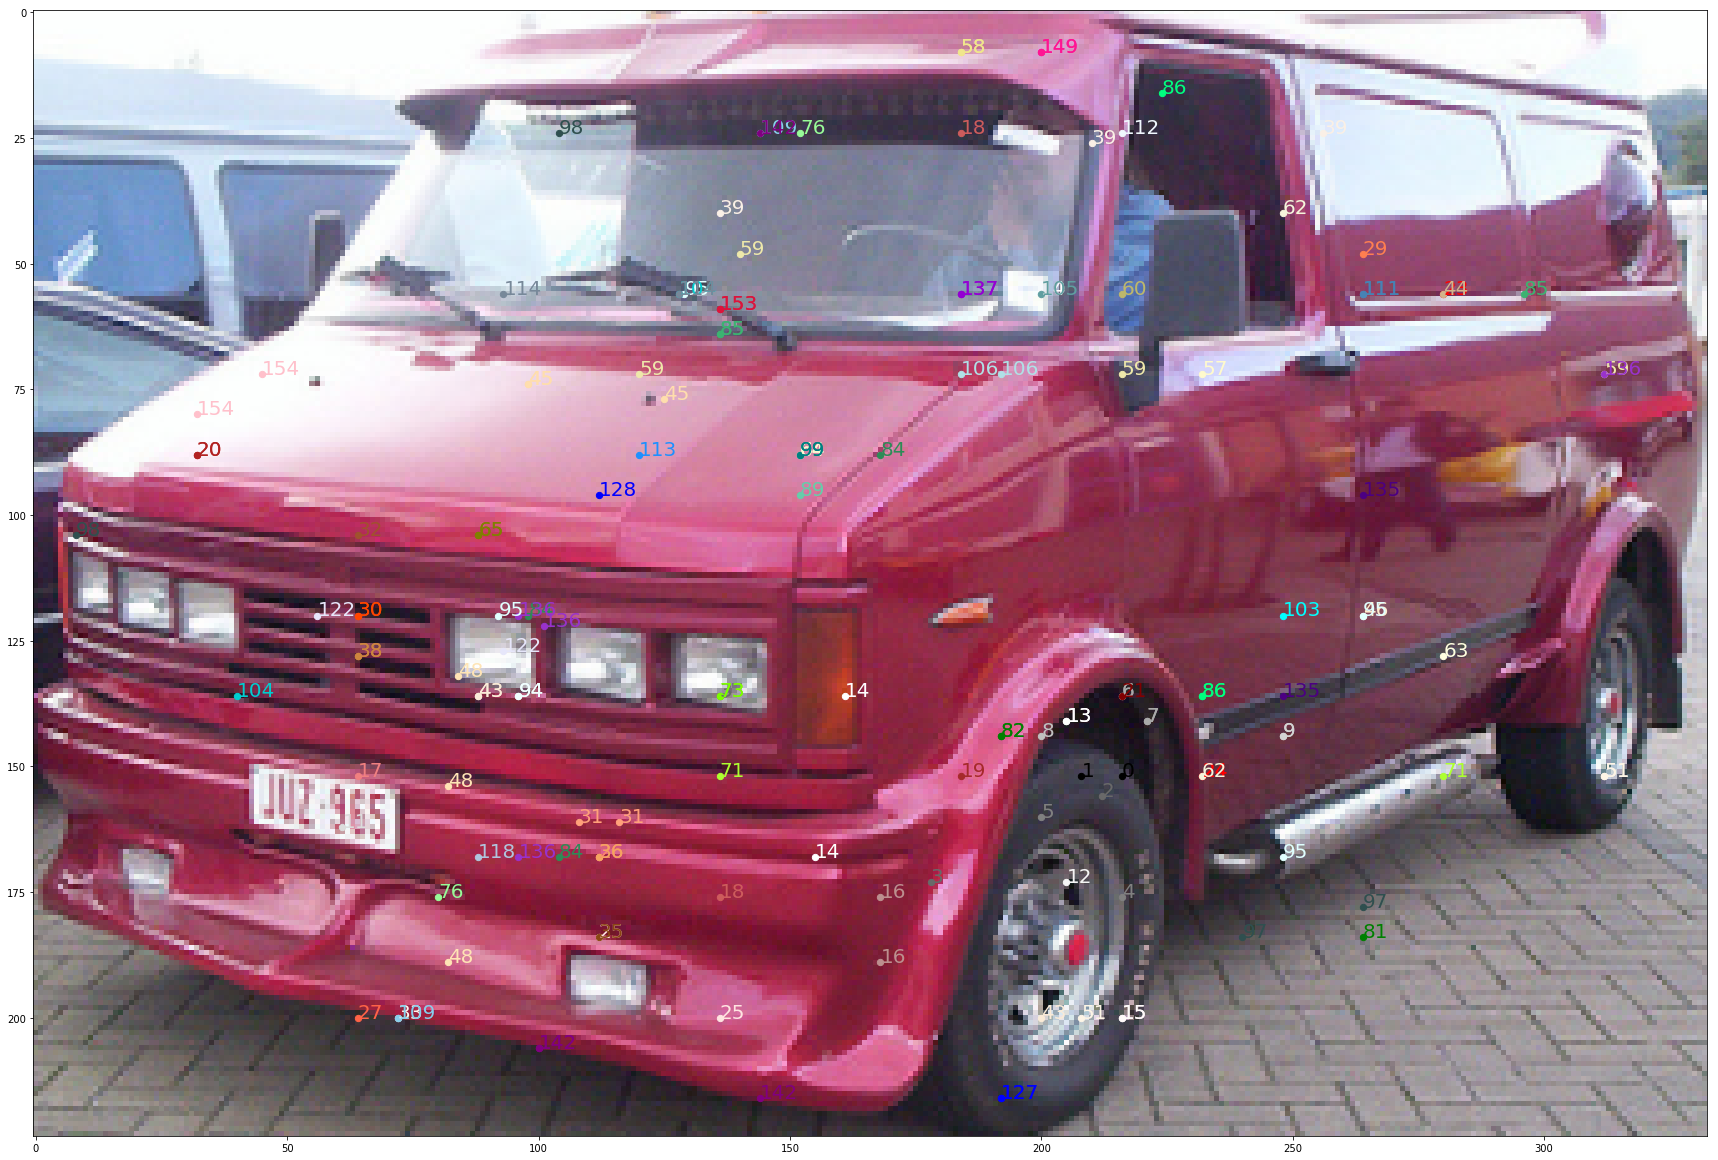

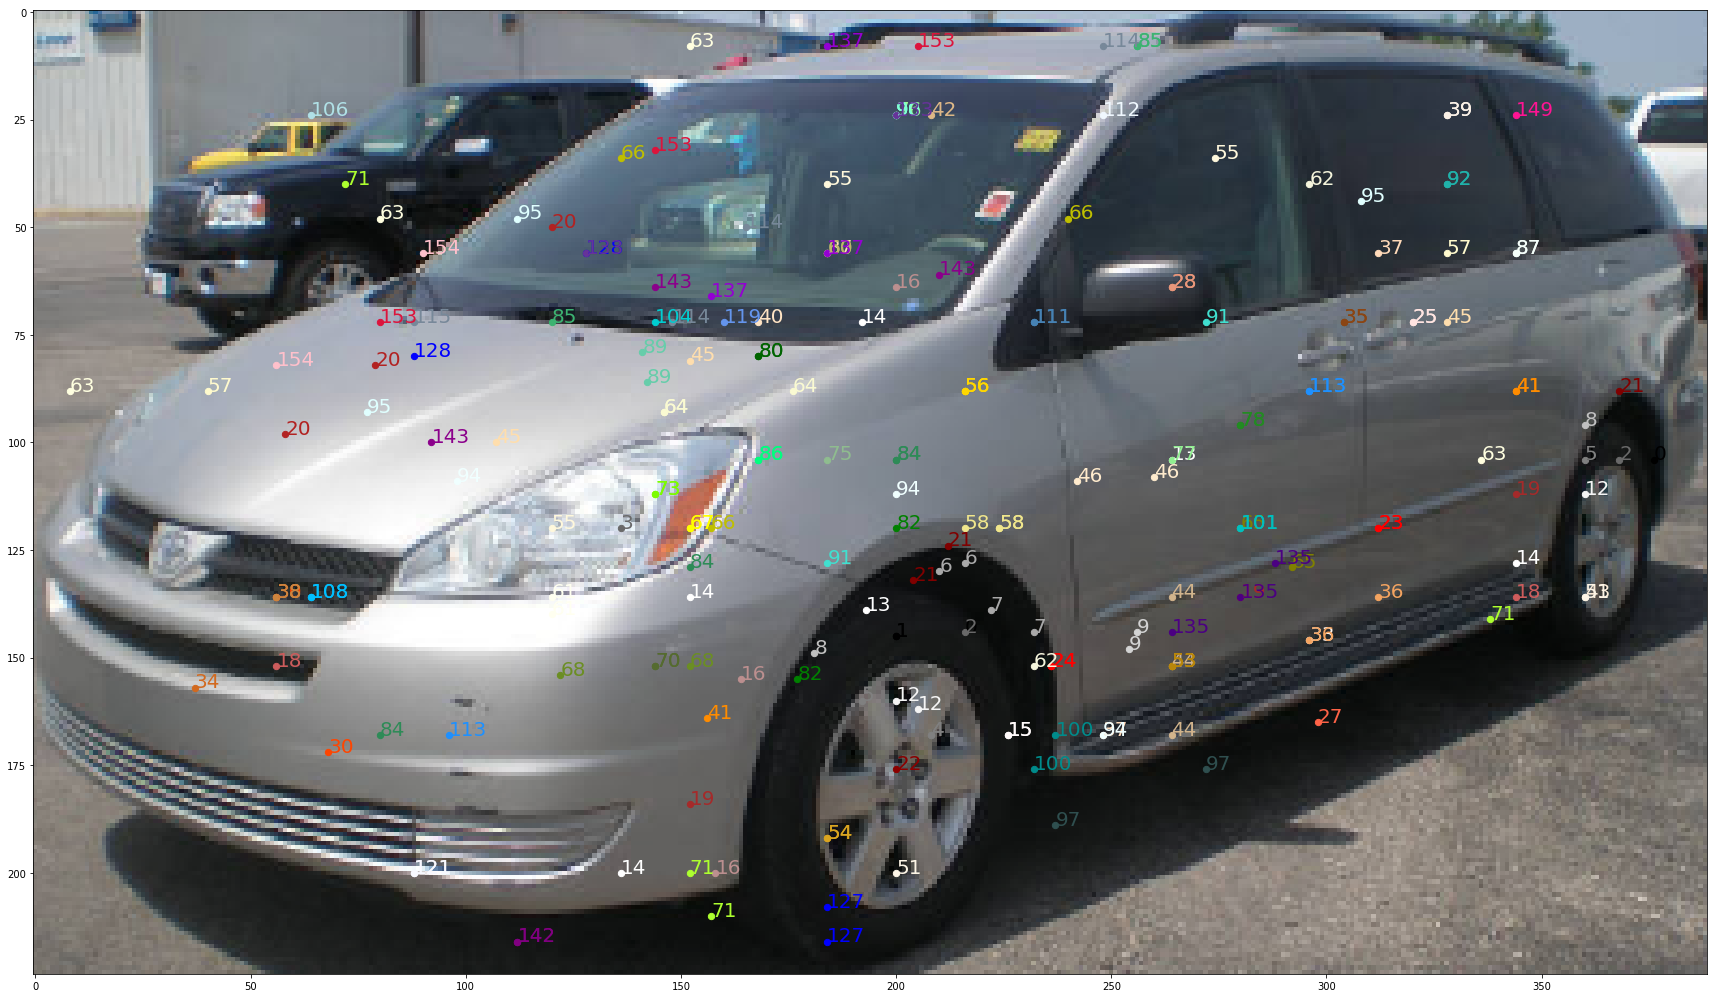

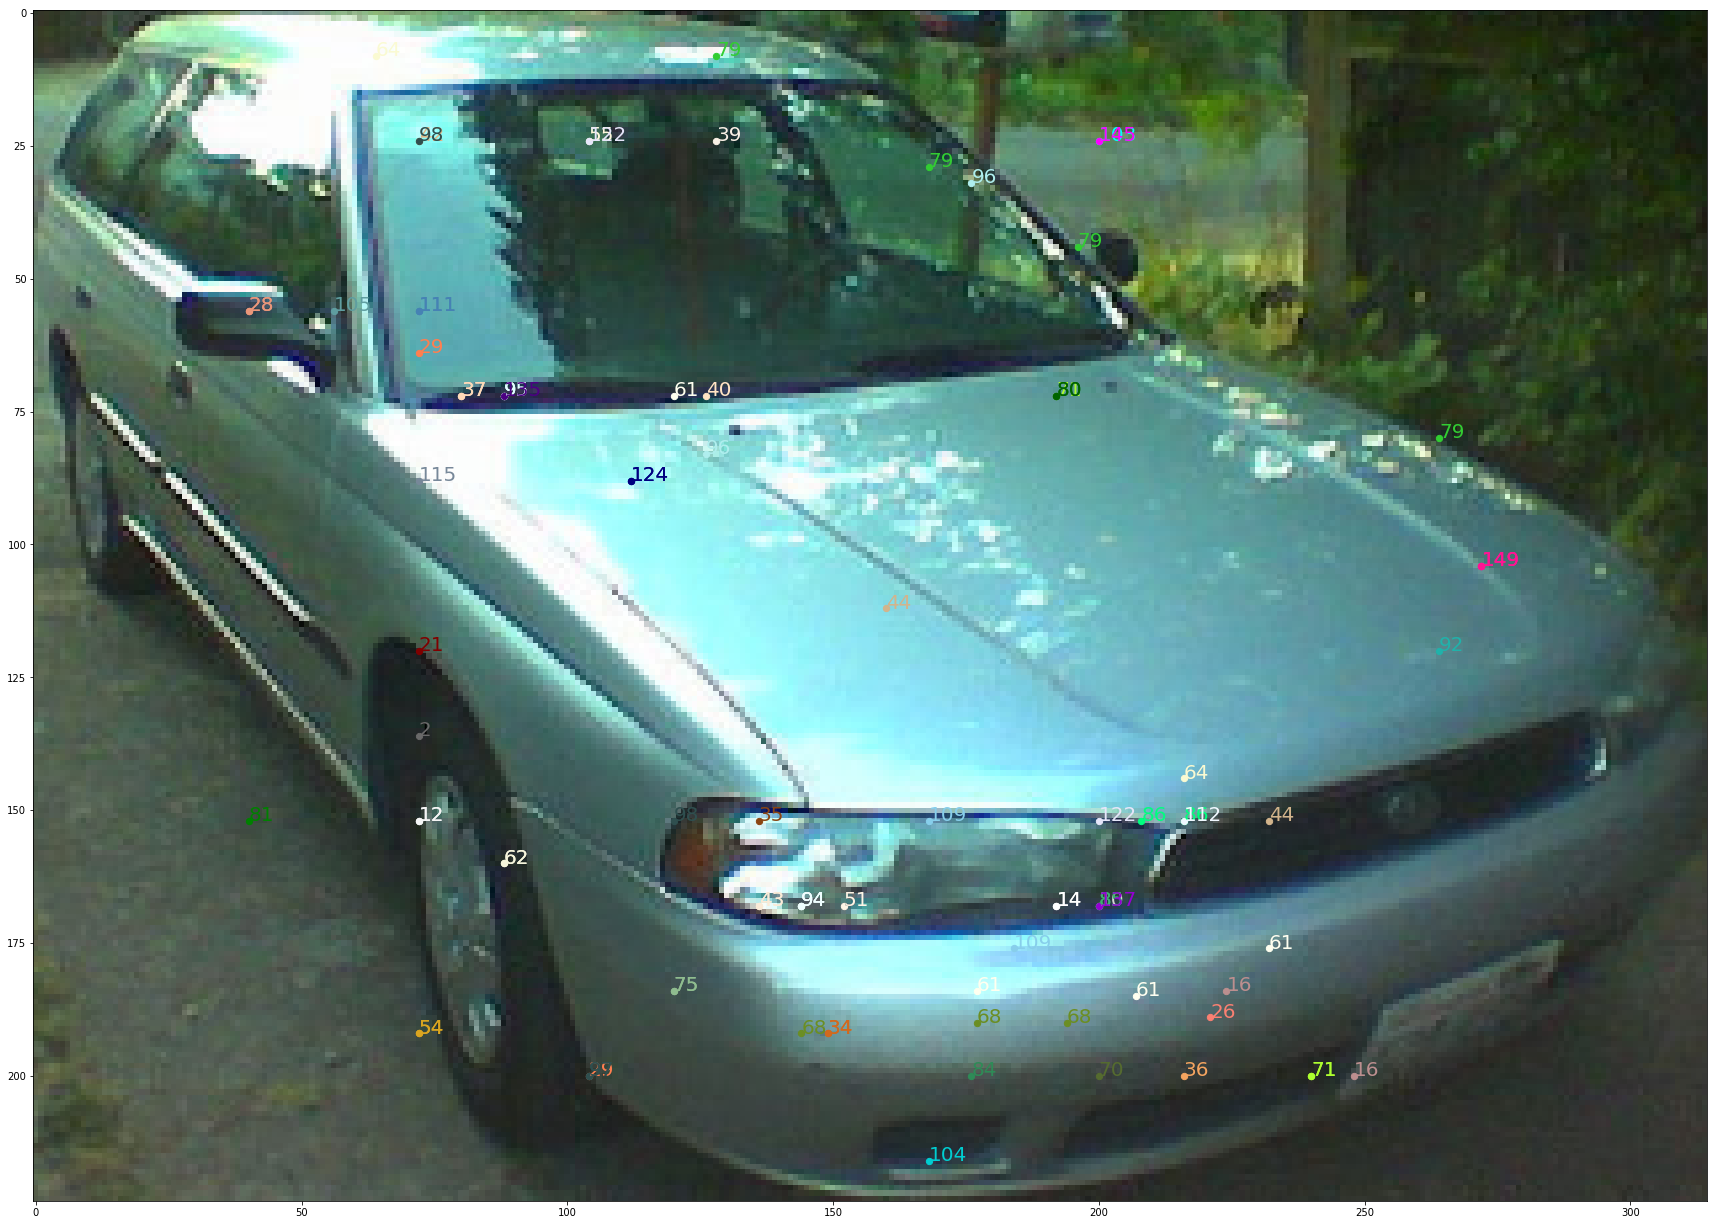

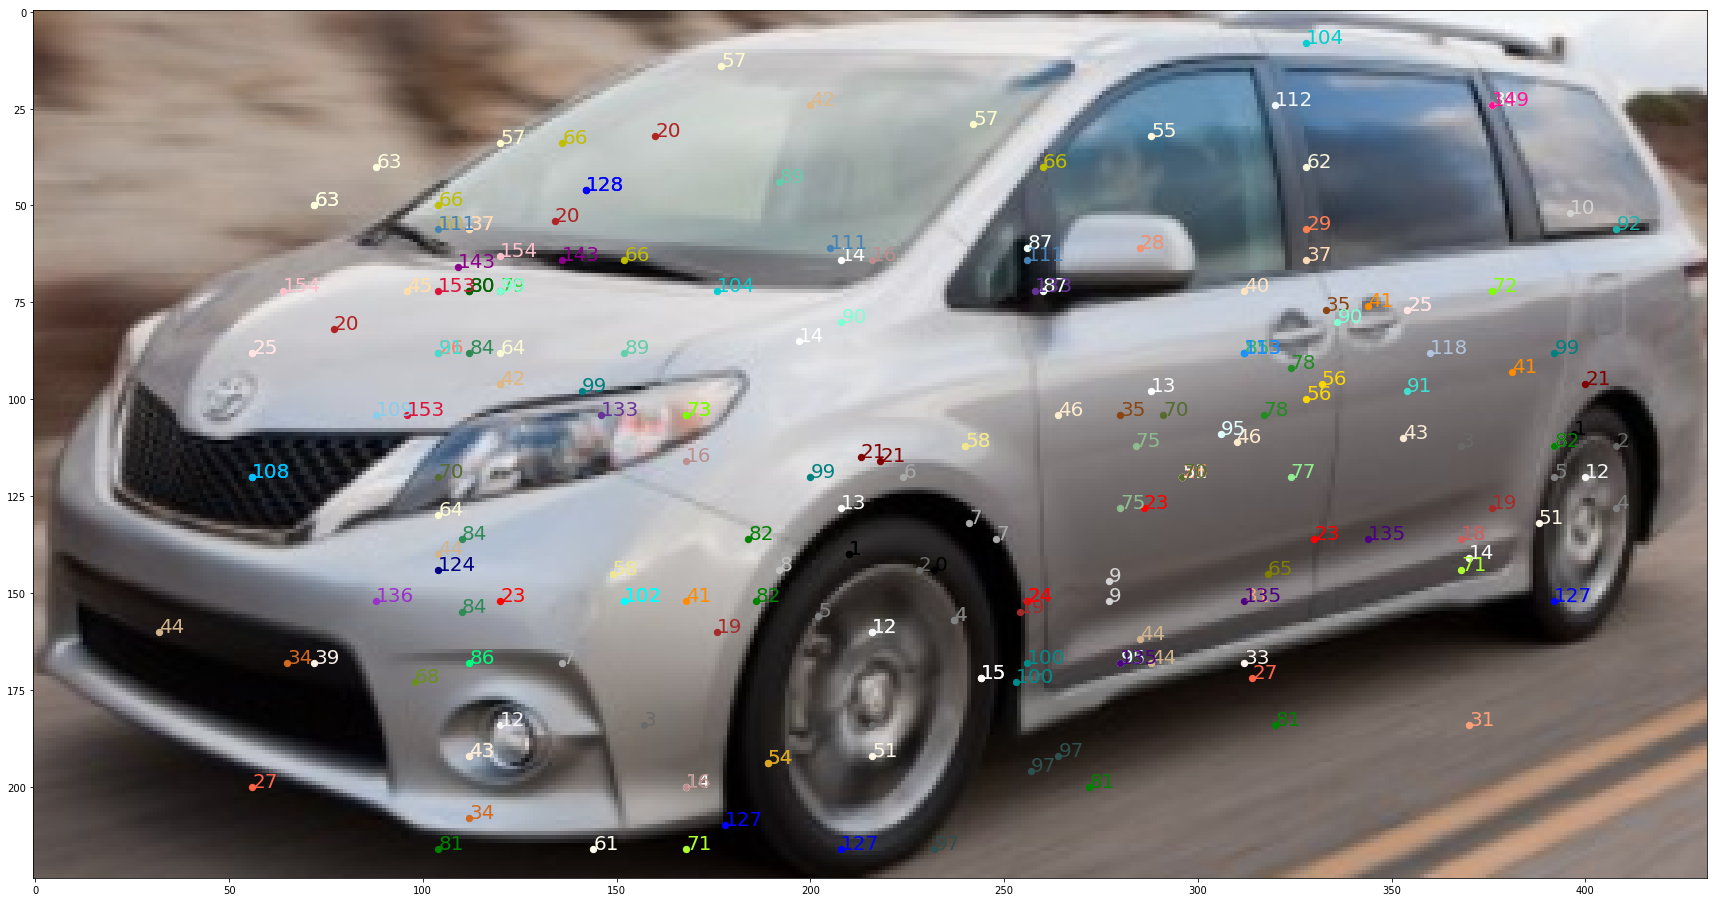

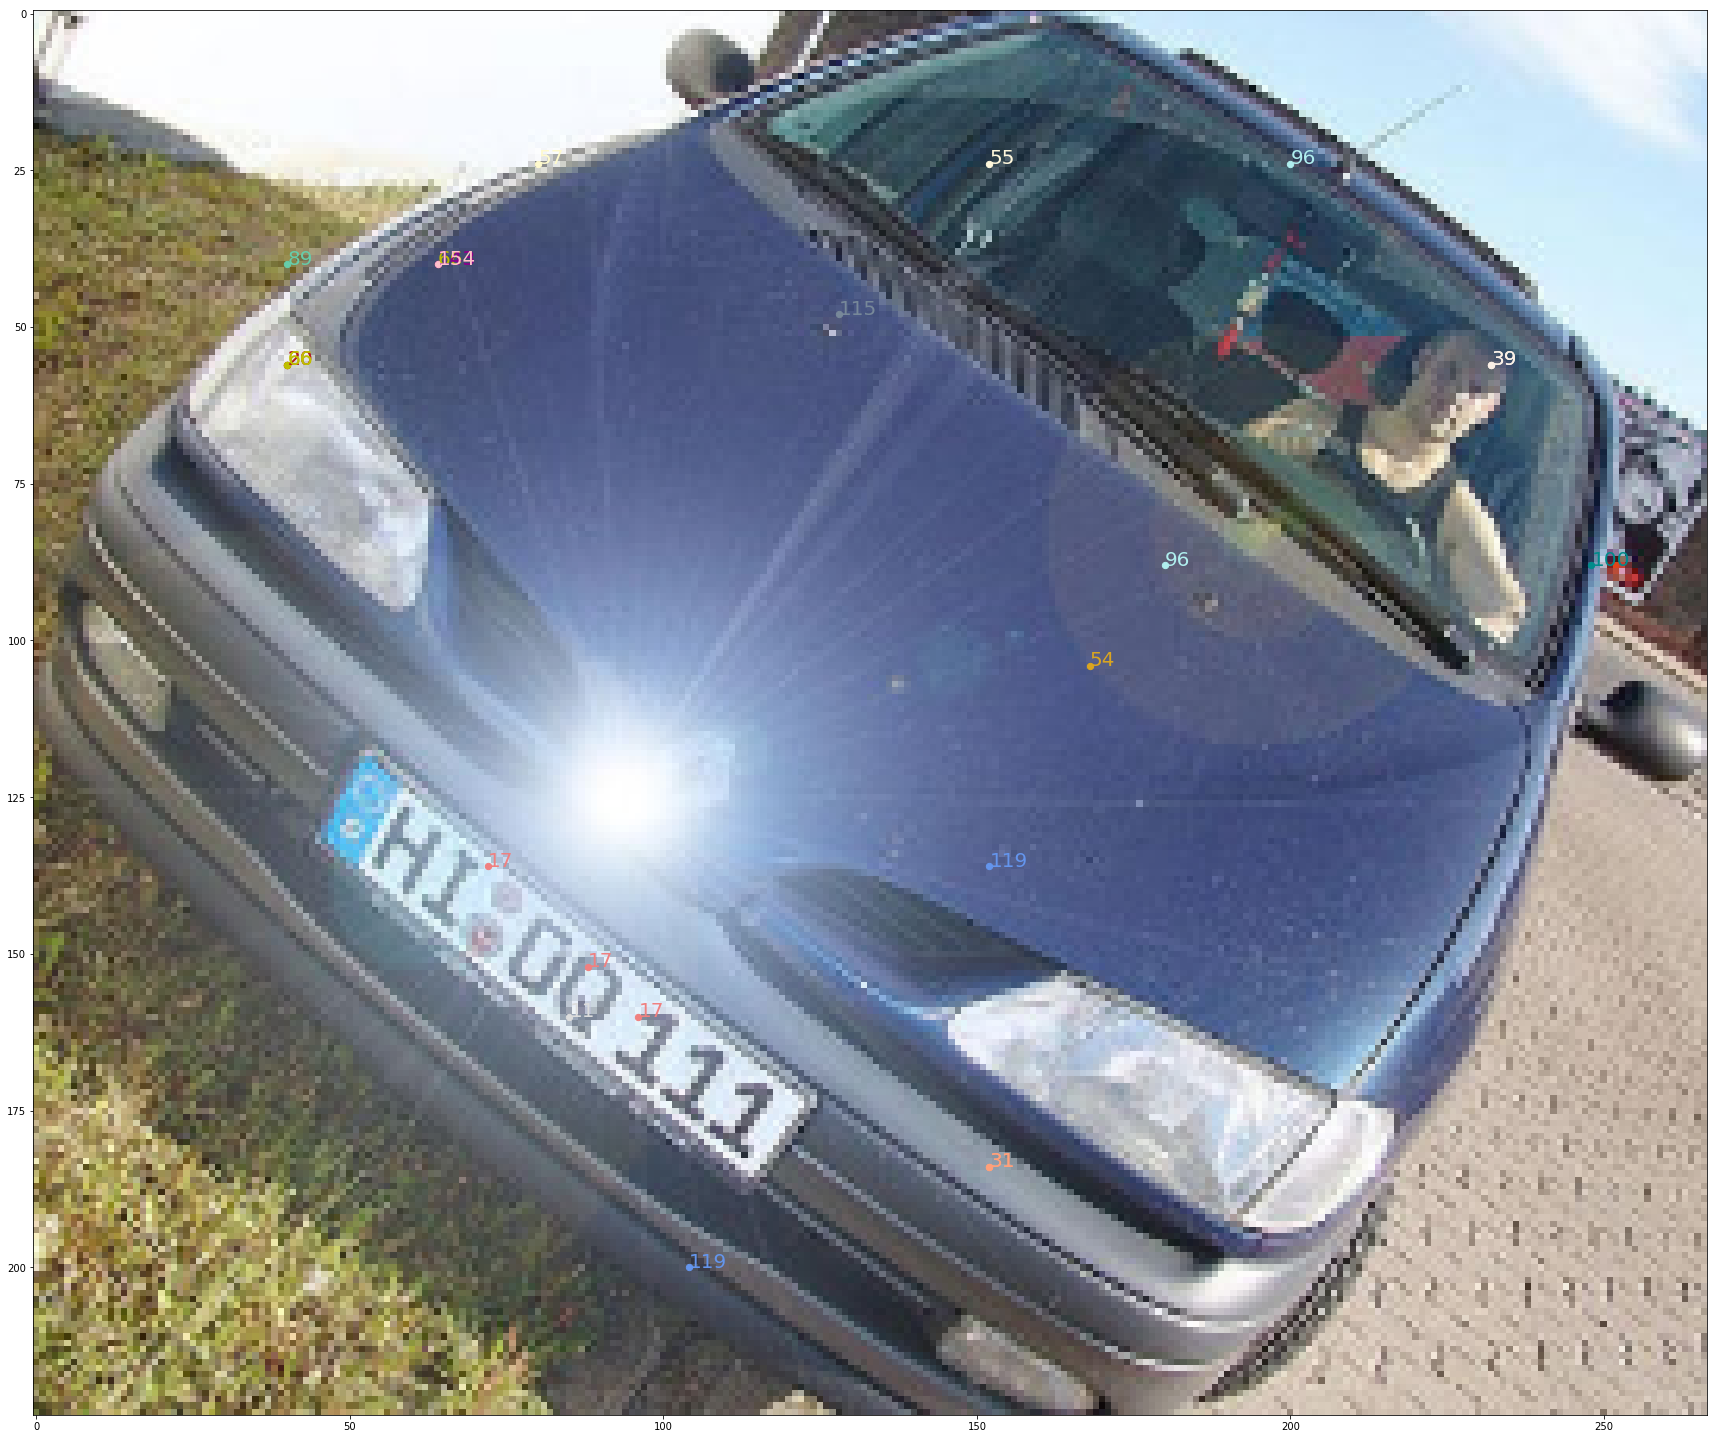

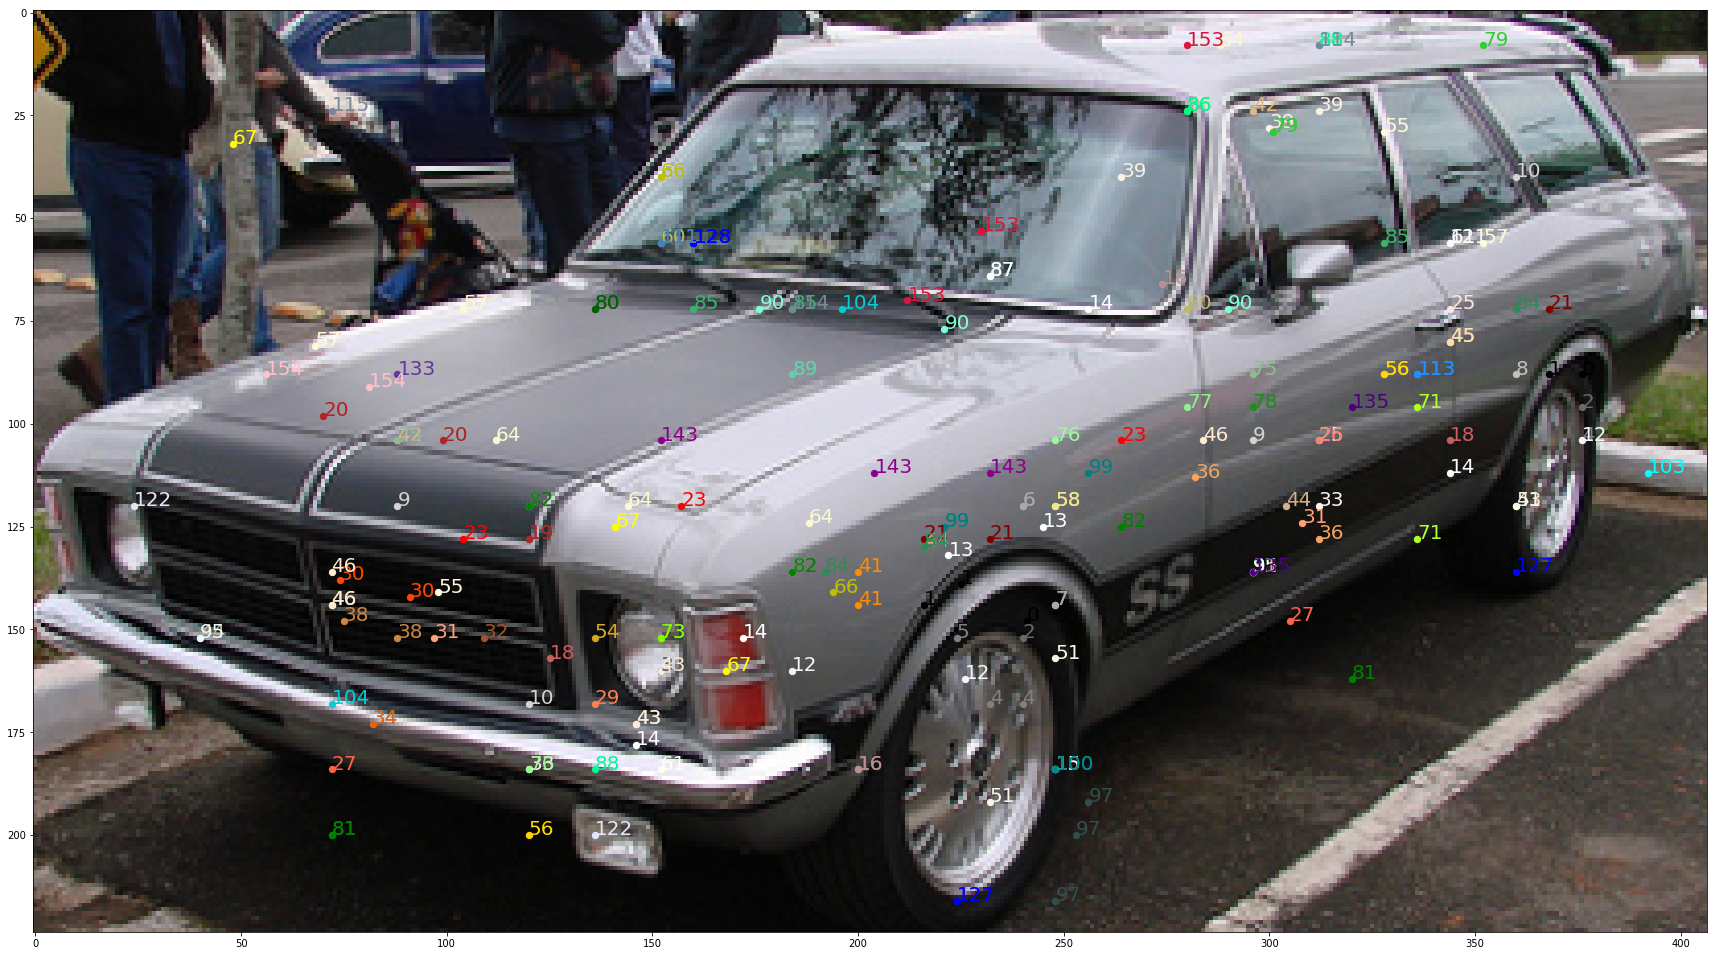

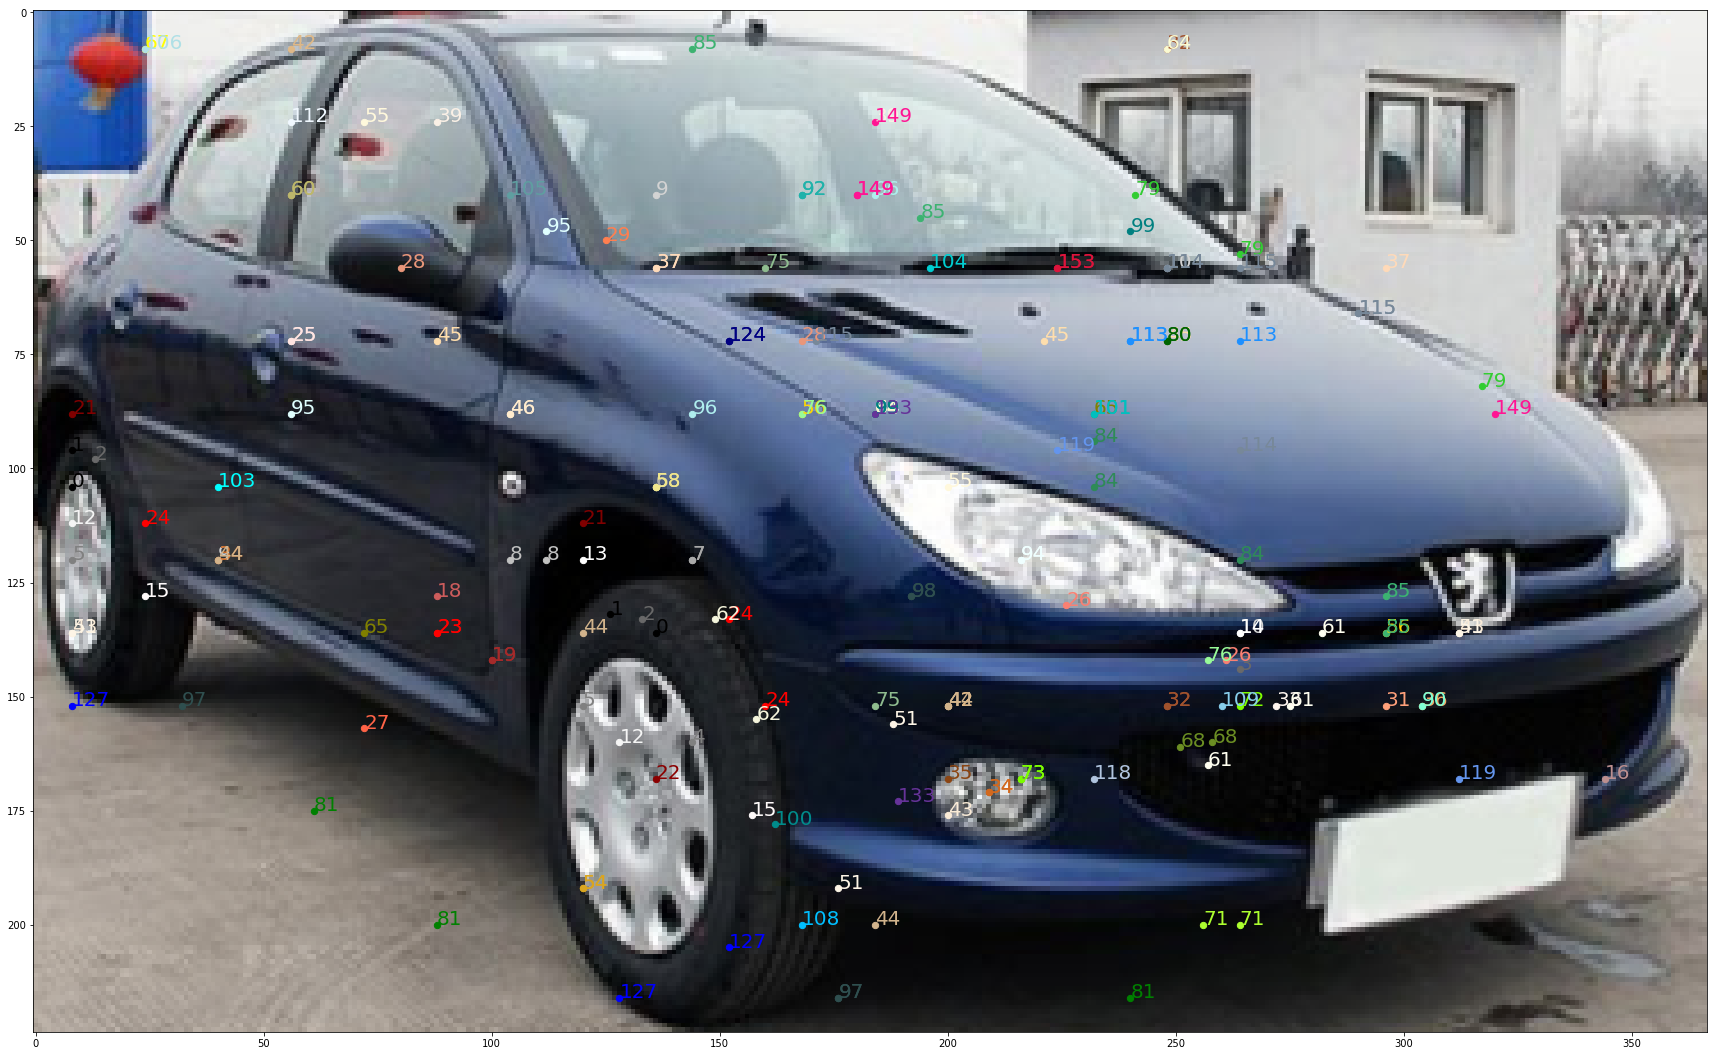

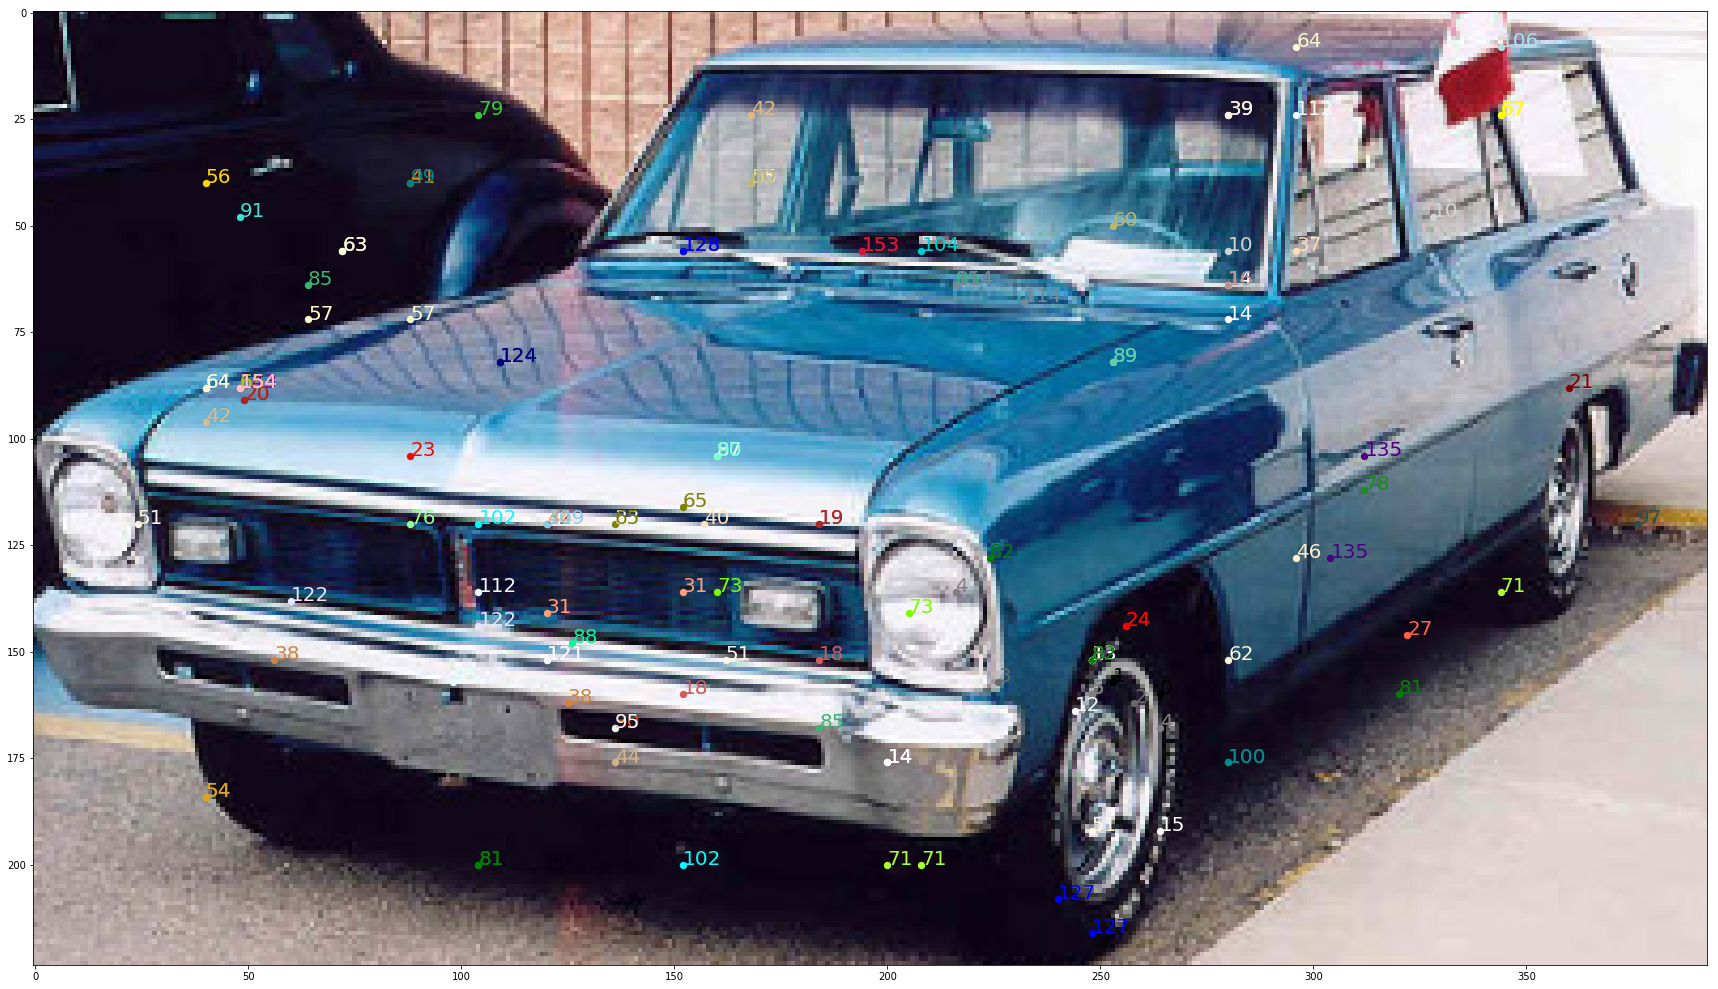

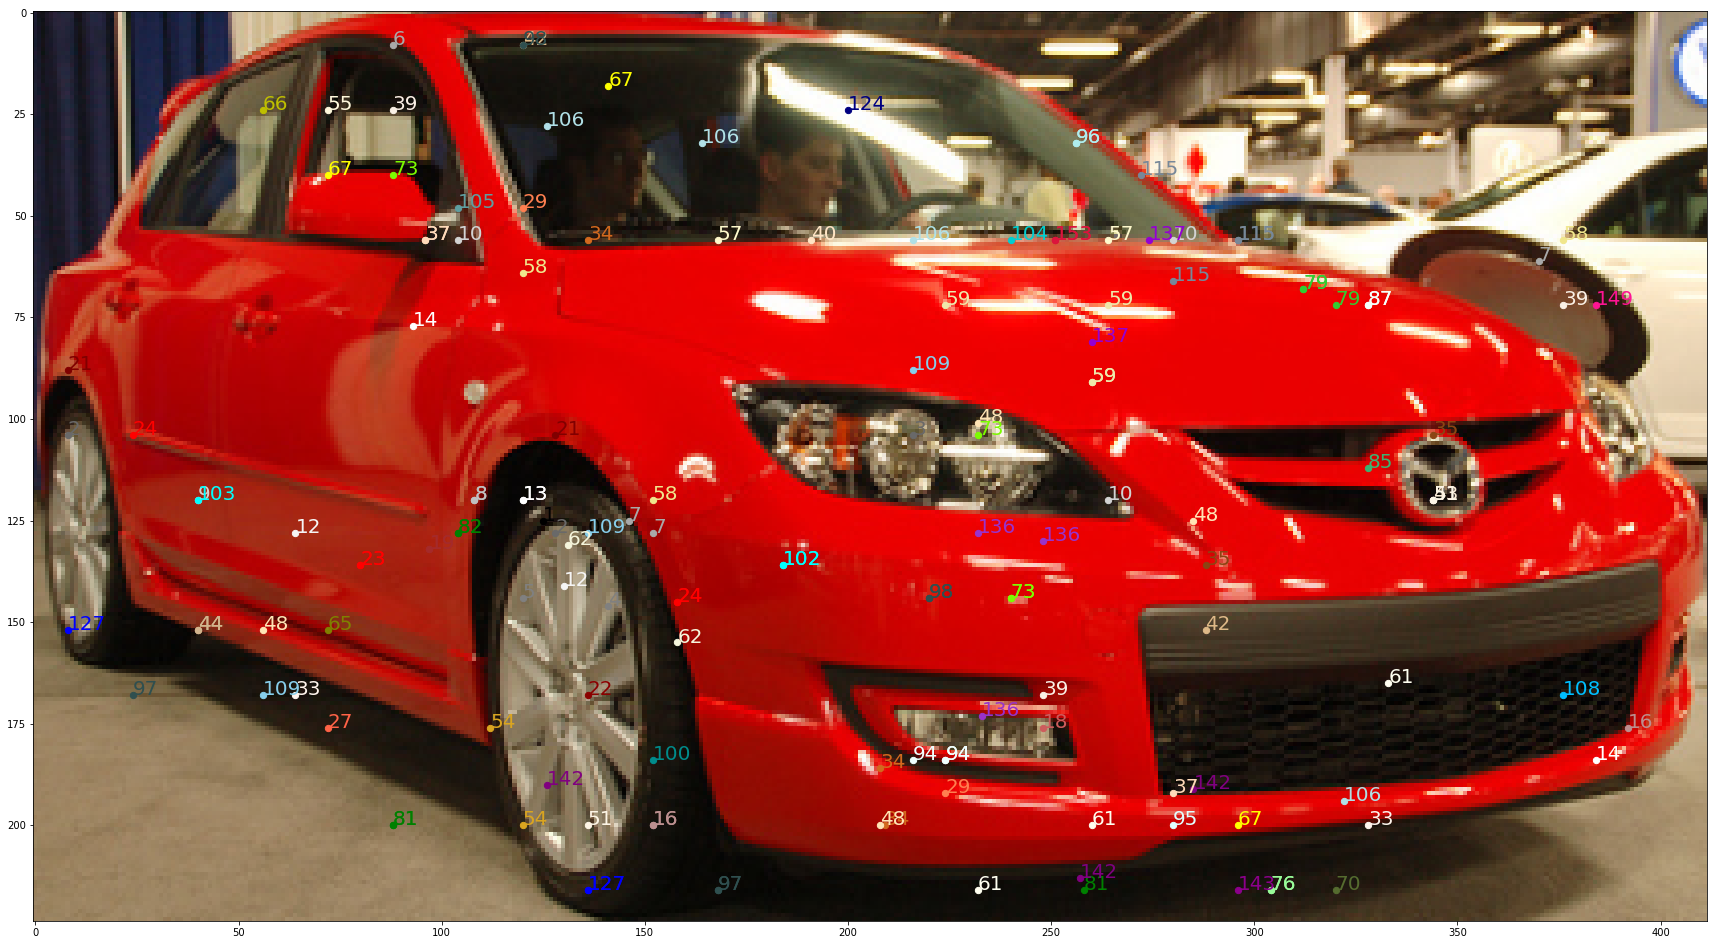

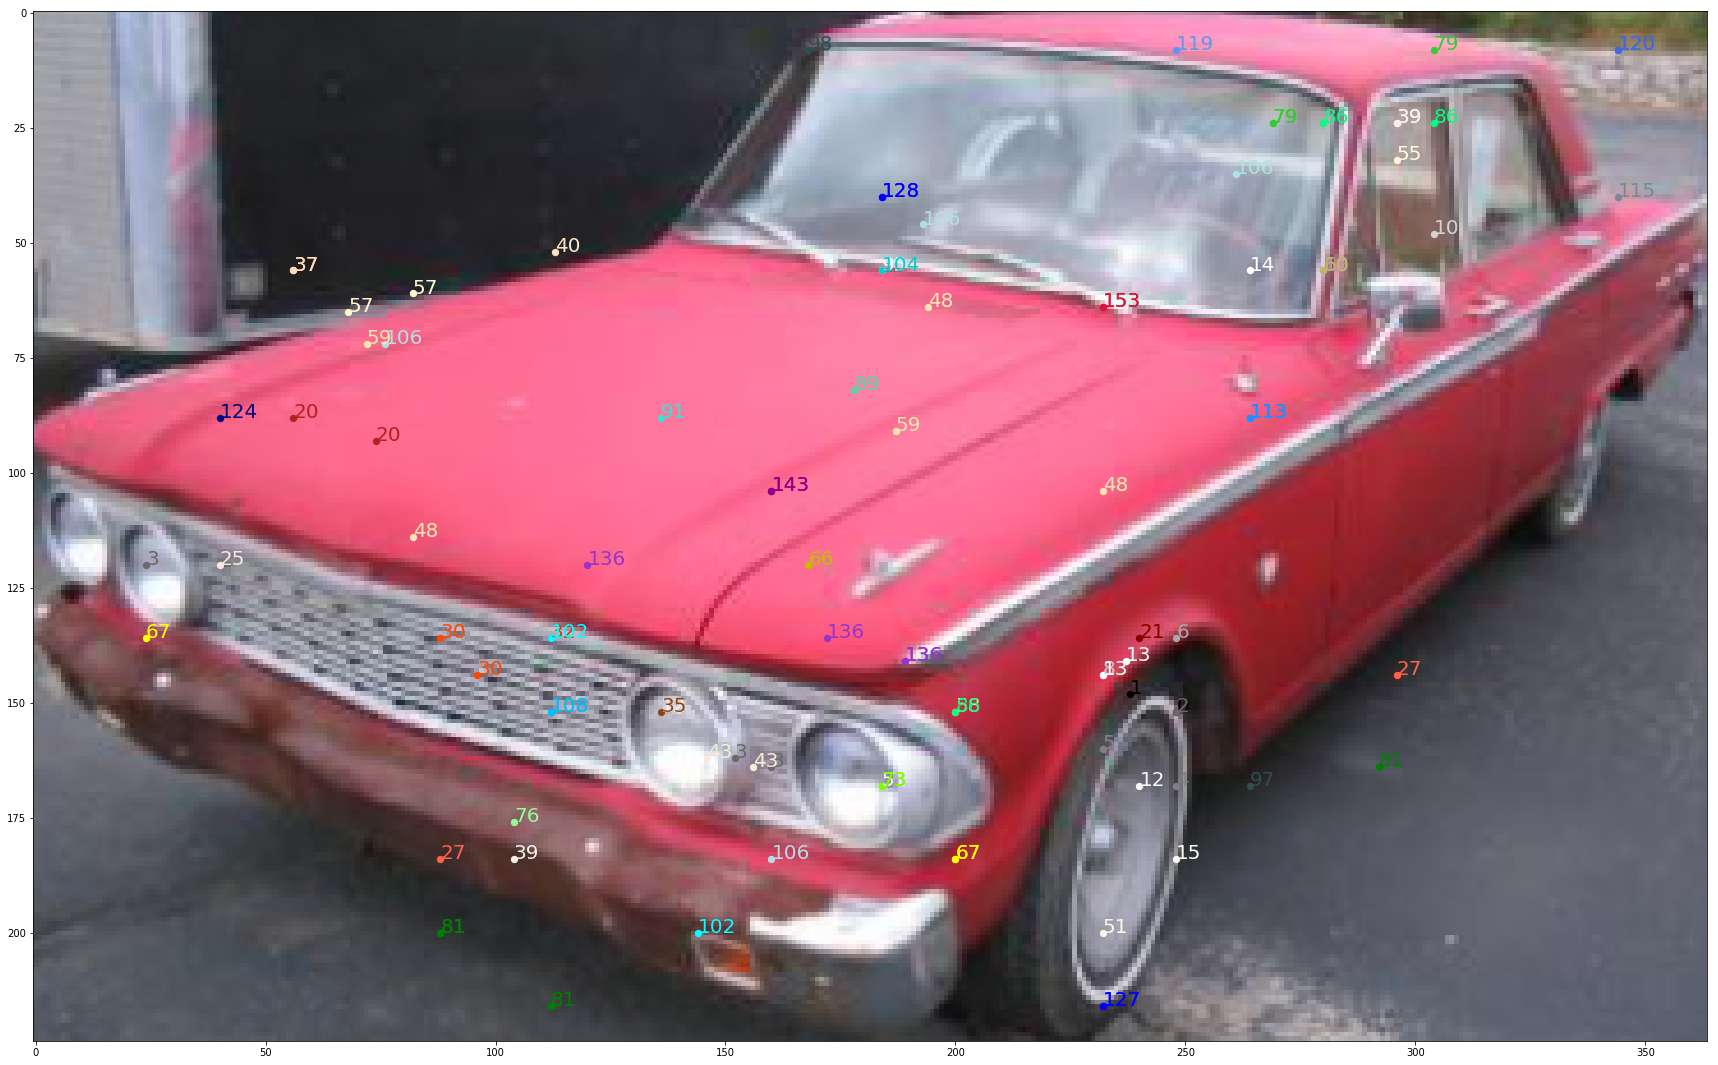

In [231]:
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

plt.rcParams['figure.figsize'] = (30.0, 30.0)
# f,ax = plt.subplots(10,1)
for img_i in range(10):
    f,ax = plt.subplots()
    ax.imshow(img_all[img_i][:,:,::-1])
    
    for vc_d in range(len(vc_dict)):
        vc_i, vc_means, vc_cov = vc_dict[vc_d]
        
        vc_l = layer_feature_b[idx_s[img_i]][:,:,vc_i]
        
        rnum, colnum = vc_l.shape
        row_i, col_i = np.where(vc_l==1)
        if row_i.size==0:
            continue
            
        pos_set = []
        for pp in range(len(row_i)):
            pos_i = [col_i[pp]-(colnum-1)/2, (rnum-1)/2-row_i[pp]]
            # only consider pixels that fall into the +-2 std range 
            if pos_i[0]>(vc_means[0]-2*np.sqrt(vc_cov[0])) and pos_i[0]<(vc_means[0]+2*np.sqrt(vc_cov[0])) and \
            pos_i[1]>(vc_means[1]-2*np.sqrt(vc_cov[1])) and pos_i[1]<(vc_means[1]+2*np.sqrt(vc_cov[1])):
                pos_set.append(pos_i)
                
        if len(pos_set) != 0:
            col_a = np.mean([pp[0] for pp in pos_set])
            row_a = np.mean([pp[1] for pp in pos_set])
            
            c_p, r_p = col_a+(colnum-1)/2, (rnum-1)/2-row_a
            r_p = int(Astride * r_p + Arf/2 - Apad)
            c_p = int(Astride * c_p + Arf/2 - Apad)
            
            ax.scatter(c_p, r_p, c=colors[sorted_names[vc_i]], s=40)
            ax.annotate(str(vc_i), (c_p, r_p), fontsize=20, color=colors[sorted_names[vc_i]])
            
    plt.show()

In [232]:
fire_pos = [[[] for vci in range(len(vc_dict))] for img_i in range(len(idx_s))]
for img_i in range(len(idx_s)):
    for vc_d in range(len(vc_dict)):
        vc_i, vc_means, vc_cov = vc_dict[vc_d]
        vc_l = layer_feature_b[idx_s[img_i]][:,:,vc_i]
        
        rnum, colnum = vc_l.shape
        row_i, col_i = np.where(vc_l==1)
        if row_i.size==0:
            continue
            
        pos_set = []
        for pp in range(len(row_i)):
            pos_i = [col_i[pp]-(colnum-1)/2, (rnum-1)/2-row_i[pp]]
            if pos_i[0]>(vc_means[0]-2*np.sqrt(vc_cov[0])) and pos_i[0]<(vc_means[0]+2*np.sqrt(vc_cov[0])) and \
            pos_i[1]>(vc_means[1]-2*np.sqrt(vc_cov[1])) and pos_i[1]<(vc_means[1]+2*np.sqrt(vc_cov[1])):
                pos_set.append(pos_i)
                
        if len(pos_set) != 0:
            ppx = np.mean([pp[0] for pp in pos_set])
            ppy = np.mean([pp[1] for pp in pos_set])
            
            xi, yi = ppx+(colnum-1)/2, (rnum-1)/2-ppy
            xi = int(Astride * xi + Arf/2 - Apad)
            yi = int(Astride * yi + Arf/2 - Apad)
            
            fire_pos[img_i][vc_d].append([xi, yi])
            
print(fire_pos[0][0]) 

[[216, 152]]


In [233]:
def min_dist(ls1, ls2):
    dd_min = 999999
    for pos1 in ls1:
        for pos2 in ls2:
            dd = np.linalg.norm(np.array(pos1)-np.array(pos2))
            if dd < dd_min:
                dd_min = dd
                
    return dd_min
    

vc_pw_dist = [np.ones((len(vc_dict), len(vc_dict))) * 999 for nn in range(len(idx_s))]
for img_n in range(len(idx_s)):
    for vc_d in range(len(vc_dict)):
        posi = fire_pos[img_n][vc_d]
        if len(posi)==0:
            continue
        
        for vc_j in range(vc_d+1, len(vc_dict)):
            posj = fire_pos[img_n][vc_j]
            if len(posj)==0:
                continue
            
            vc_pw_dist[img_n][vc_d, vc_j] = min_dist(posi, posj)
            
    vc_pw_dist[img_n] = np.minimum(vc_pw_dist[img_n], vc_pw_dist[img_n].T)  # symmetrize the matrix
    

print(vc_pw_dist[len(idx_s)-1])

[[ 999.          999.          186.02419198 ...,  999.          999.          999.        ]
 [ 999.          999.          999.         ...,  999.          999.          999.        ]
 [ 186.02419198  999.          999.         ...,  999.          999.          999.        ]
 ..., 
 [ 999.          999.          999.         ...,  999.          999.          999.        ]
 [ 999.          999.          999.         ...,  999.          999.          999.        ]
 [ 999.          999.          999.         ...,  999.          999.          999.        ]]


In [234]:
vc_i = 66
vc_d_idx = np.where([dd[0]==vc_i for dd in vc_dict])[0]
print('VC{0} has {1} components'.format(vc_i, len(vc_d_idx)))

count_arr = np.zeros((len(vc_d_idx), len(vc_dict)))
for img_n in range(len(idx_s)):
    count_arr += vc_pw_dist[img_n][vc_d_idx,:] <= 50
    
vc_ls_all = []
for dd in range(len(vc_d_idx)):
    vc_ls = np.where(count_arr[dd] >= len(idx_s)/5)[0]
    vc_ls = np.append(vc_ls, vc_d_idx[dd])
    print(vc_ls)
    vc_ls_all.append(vc_ls)

VC66 has 4 components
[ 71 192 392 393 213]
[192 193 268 393 214]
[215]
[216]


In [235]:
def ls_add(ls_all, ls):
    if len(ls_all)!=0:
        to_del = []
        for li,ll in enumerate(ls_all):
            if len(set(ll)&set(ls))/min(len(ll), len(ls)) >= 0.8 or min(len(ll), len(ls))-len(set(ll)&set(ls))<=2:
                to_del.append(li)
                ls = list(set(ll)|set(ls))
                
        ls_all = [ll for li, ll in enumerate(ls_all) if li not in to_del]
        
    ls_all.append(ls)
    return(ls_all)

In [238]:
vc_ls_all = []
for vc_d in range(len(vc_dict)):
    count_arr = np.zeros(len(vc_dict))
    for img_n in range(len(idx_s)):
        count_arr += vc_pw_dist[img_n][vc_d,:] <= 50
        
    idx_sort = np.argsort(-count_arr)
    idx_select = np.where(count_arr >= len(idx_s)/5)[0]
    vc_ls = [ii for ii in idx_sort[0:10] if ii in idx_select]
    vc_ls = np.append(vc_ls, vc_d)    
    if len(vc_ls) > 3:
        vc_ls_all = ls_add(vc_ls_all, list(vc_ls))
        
print(len(vc_ls_all))

36


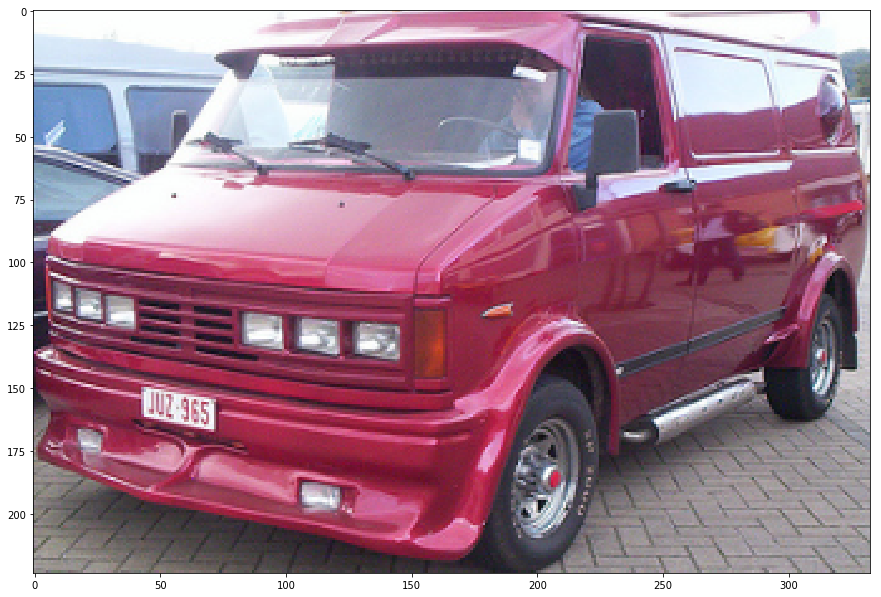

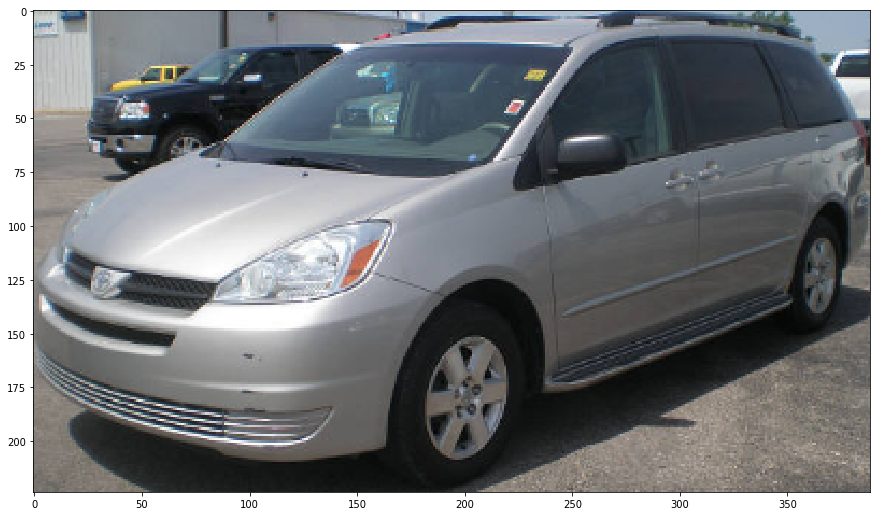

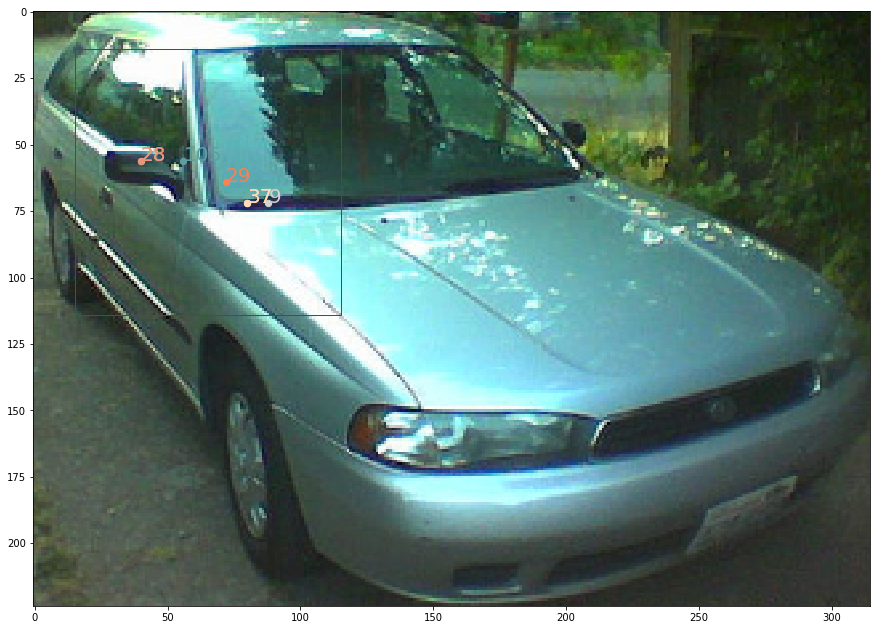

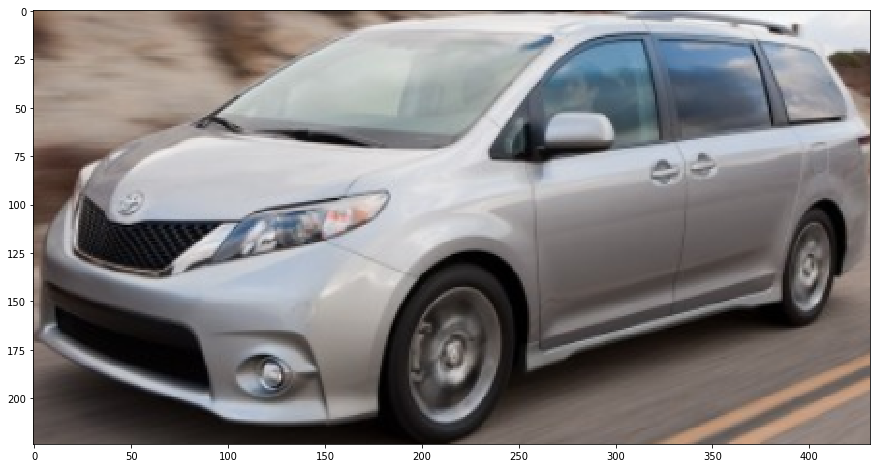

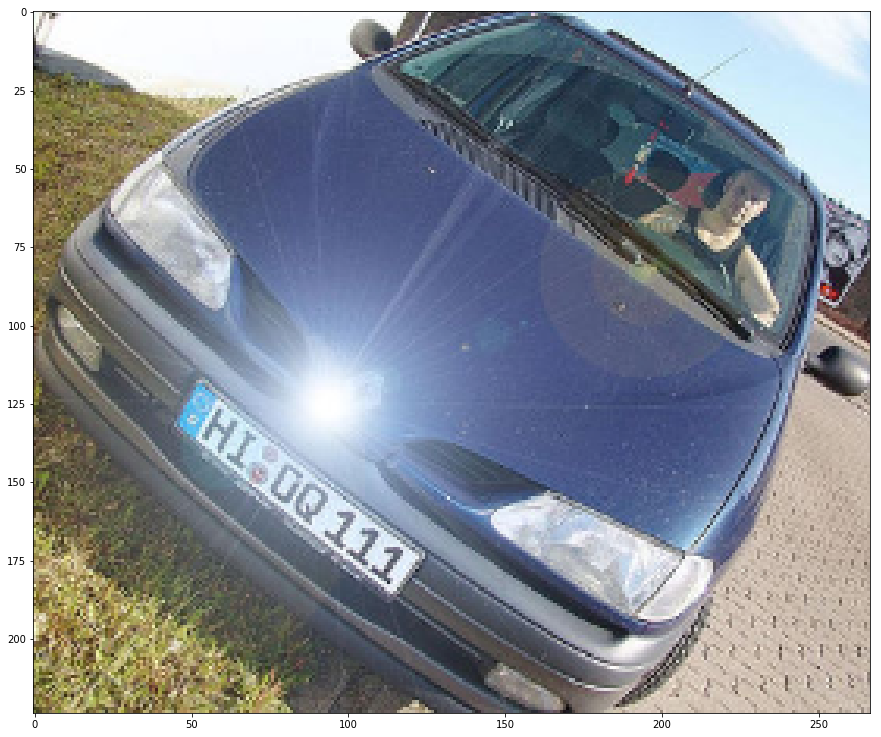

In [244]:
import matplotlib.patches as patches
'''
plt.rcParams['figure.figsize'] = (30.0, 30.0)
# f,ax = plt.subplots(10,1)
vc_ls = vc_ls_all[3]
for img_i in range(10):
    f,ax = plt.subplots()
    ax.imshow(img_all[img_i][:,:,::-1])
    
    imgh,imgw=img_all[img_i].shape[0:2]
    for bbh in range(0,imgh-100,20):
        for bbw in range(0,imgw-100,20):
            vc_cnt = 0
            tmp = []
            for vc_d in vc_ls:
                if len(fire_pos[img_i][vc_d])==0:
                    continue
                    
                for pp in fire_pos[img_i][vc_d]:
                    if pp[0]>=bbw and pp[0]<=bbw+100 and pp[1]>=bbh and pp[1]<=bbh+100:
                        vc_cnt += 1
                        tmp.append([vc_dict[vc_d][0], pp[0],pp[1]])
                        
            if vc_cnt >= len(vc_ls)/2:
                for tt in tmp:
                    ax.scatter(tt[1],tt[2],c=colors[sorted_names[tt[0]]], s=40)
                    ax.annotate(str(tt[0]), (tt[1],tt[2]), fontsize=20, color=colors[sorted_names[tt[0]]])
                    
                rect = patches.Rectangle((bbw,bbh),100,100,linewidth=1, edgecolor='red',facecolor='none')
                ax.add_patch(rect)
            
    plt.show()
'''
plt.rcParams['figure.figsize'] = (15.0, 15.0)
# f,ax = plt.subplots(10,1)
vc_ls = vc_ls_all[3]
for img_i in range(0,5):
    f,ax = plt.subplots()
    ax.imshow(img_all[img_i][:,:,::-1])
    
    tmp = []
    for vc_d in vc_ls:
        if len(fire_pos[img_i][vc_d])==0:
            continue
        
        tmp.append([vc_dict[vc_d][0], fire_pos[img_i][vc_d][0][0], fire_pos[img_i][vc_d][0][1]])
        
    if len(tmp)>len(vc_ls)/2:
        for tt in tmp:
            ax.scatter(tt[1],tt[2],c=colors[sorted_names[tt[0]]], s=40)
            ax.annotate(str(tt[0]), (tt[1],tt[2]), fontsize=20, color=colors[sorted_names[tt[0]]])
            
        xx = np.mean([tt[1] for tt in tmp])-50
        yy = np.mean([tt[2] for tt in tmp])-50
        rect = patches.Rectangle((xx,yy),100,100,linewidth=1, edgecolor='red',facecolor='none')
        ax.add_patch(rect)
        
        
    plt.show()

In [205]:
for vl in vc_ls_all:
    print(vl)

[56, 25, 44, 241, 51, 202, 203, 17, 79, 118, 55]
[71, 51, 70, 204, 53, 56, 44, 117, 104, 213, 69]
[71, 225, 226, 138, 69, 227, 89, 137, 230, 186, 70]
[70, 225, 226, 138, 69, 89, 186, 271, 94, 213, 71]
[94, 79, 272, 186, 138, 143, 199, 28, 225, 187, 80]
[69, 70, 71, 271, 79, 87, 89, 94, 226, 103, 104, 186]
[129, 138, 143, 80, 79, 278, 89, 28, 94, 31, 230, 186, 187]
[352, 1, 66, 37, 6, 15, 47, 48, 16, 146, 149, 150, 283]
[57, 16, 150, 352, 148, 67, 26, 37, 18, 35, 149]
[55, 71, 44, 202, 70, 79, 69, 51, 56, 204, 203]
[199, 201, 154, 155, 80, 222, 207, 265, 219, 225, 208]
[229, 213, 137, 38, 117, 118, 227, 69, 99, 218, 215]
[129, 70, 71, 138, 271, 216, 28, 94, 31, 225, 230, 186]
[198, 137, 219, 226, 227, 266, 138, 207, 276, 70, 218]
[138, 230, 227, 218, 137, 155, 198, 154, 70, 226, 219]
[138, 226, 71, 70, 230, 94, 80, 187, 79, 186, 225]
[70, 71, 137, 138, 80, 213, 89, 154, 219, 28, 225, 226, 227, 229, 230]
[128, 130, 72, 136, 139, 140, 277, 214, 22, 29, 224, 160, 228, 174, 176]
[69, 198, 7

In [224]:

# f,ax = plt.subplots(10,1)
for vc_ls_i, vc_ls in enumerate(vc_ls_all):
    fname = 'vc_ls_examples_{0}.png'.format(vc_ls_i)
    plt.rcParams['figure.figsize'] = (30.0, 75.0)
    f,ax = plt.subplots(5,1)
    for img_i in range(5):
        ax[img_i].imshow(img_all[img_i][:,:,::-1])
        
        tmp = []
        for vc_d in vc_ls:
            if len(fire_pos[img_i][vc_d])==0:
                continue
            
            tmp.append([vc_dict[vc_d][0], fire_pos[img_i][vc_d][0][0], fire_pos[img_i][vc_d][0][1]])
            
        if len(tmp)>=len(vc_ls)/2:
            for tt in tmp:
                ax[img_i].scatter(tt[1],tt[2],c=colors[sorted_names[tt[0]]], s=40)
                ax[img_i].annotate(str(tt[0]), (tt[1],tt[2]), fontsize=20, color=colors[sorted_names[tt[0]]])
                
            xx = np.mean([tt[1] for tt in tmp])-50
            yy = np.mean([tt[2] for tt in tmp])-50
            rect = patches.Rectangle((xx,yy),100,100,linewidth=1, edgecolor='red',facecolor='none')
            ax[img_i].add_patch(rect)
            
            
    f.savefig(fname, bbox_inches='tight')
    plt.close()

In [225]:
print(vc_ls_all[3])
print(vc_ls_all[-3])

[70, 225, 226, 138, 69, 89, 186, 271, 94, 213, 71]
[153, 159, 167, 169, 107, 108, 372, 121, 59, 189]


In [239]:
ss = set([])
for vl in vc_ls_all:
    ss = ss|set(vl)
    
print(len(ss))

215
